This notebook picks up where the other left off, because it's on a local workstation with PyPlot.

In [5]:
using PyPlot
plt[:style][:use]("ggplot")

In [4]:
exp_params = Dict()
dir = joinpath(homedir(), "seungmount/research/Alembic/datasets/davit_piritest")
exp_dirs = ["standard_224", "standard_160", "across_224", "across_160"]
ms_names = ["original", "net_adj", "net_across", "bandpass"]
for exp in exp_dirs
    exp_params[exp] = Dict()
    for ms in ms_names
        fn = join([exp, ms], "_")
        exp_params[exp][ms] = readdlm(joinpath(homedir(), dir, string(fn, "_params.csv")))
    end
end

        filtered = ones(m)
        filtered[collect(get_rejected_indices(match))] = 0
        dist = get_properties(match, "norm")
        r_max = get_properties(match, "r_max")
        sigma = get_properties(match, 0.75)
        r_delta = get_properties(match, 10)
        params = hcat(filtered, dist, r_max, sigma, r_delta)

In [6]:
exp_params

Dict{Any,Any} with 4 entries:
  "across_160"   => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 40.353 … 6.4590…
  "across_224"   => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 37.1512 … 8.676…
  "standard_160" => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 16.5007 … 2.596…
  "standard_224" => Dict{Any,Any}(Pair{Any,Any}("bandpass",[1.0 16.543 … 2.4200…

In [7]:
standard_224 = exp_params["standard_224"]

Dict{Any,Any} with 4 entries:
  "bandpass"   => [1.0 16.543 … 2.42008 0.156665; 1.0 16.5923 … 2.46526 0.23957…
  "original"   => [1.0 16.5949 … 3.30224 0.157133; 1.0 16.6178 … 3.32499 0.2563…
  "net_adj"    => [1.0 17.1376 … 7.1877 0.435392; 1.0 17.1393 … 7.52087 0.56422…
  "net_across" => [1.0 16.6307 … 6.39829 0.399027; 1.0 17.1251 … 6.63302 0.5563…

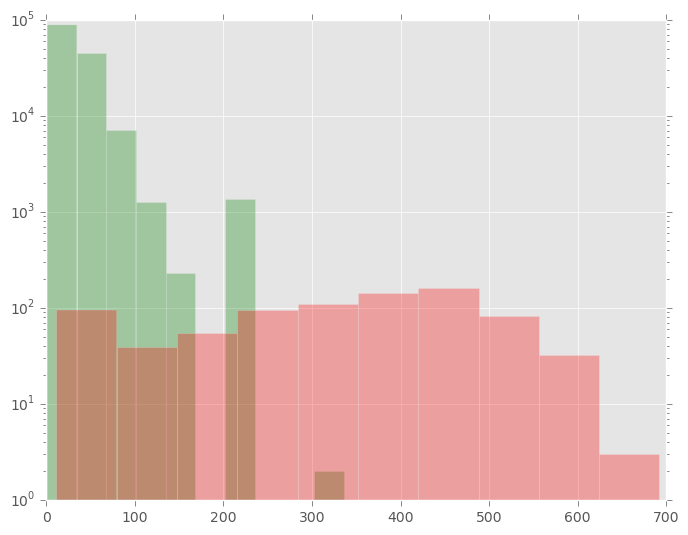

In [16]:
s224o = standard_224["original"]
plt[:hist](s224o[s224o[:,1] .== 1, 2], bins=10, color="g", alpha=0.3)
plt[:hist](s224o[s224o[:,1] .== 0, 2], bins=10, color="r", alpha=0.3)
ax = gca()
ax[:set_yscale]("log")

In [ ]:
function